# A Crowdfunding Campaign Prognostic Tool
## Project Summary
Over the last few years crowdfunding has become one of the major sources of capital for startup companies. No matter what the complexity or size of the project is, startups can use crowdfunding websites like Kickstarter and Indiegogo to present their innovative ideas and prototypes to the public. On the other hand, investors with all scales of budget can pre-order the products.
As a person with firsthand experience in crowdfunding projects, I believe there are several factors affecting the success of a campaign other that the idea or the quality of the product. At any time, there are more than 15,000 live campaigns running on Kickstarter and Indiegogo and there are other websites that provide the same service as well. Therefore, it is really a challenging task to become noticeable among the huge crowd of projects. Other than advertisement, there are several tuning parameters that should be considered in order to increase the chance of success for a project, like the effect of the campaign duration, the number of tiers, the presence of a video, number of team members, etc. Furthermore, Indiegogo and Kickstarter have different policies regarding the completeness of the product, therefore, different campaign designs should be considered for each of them. 
In this work, a Crowdfunding Campaign Prognostic Tool will be designed that automatically reviews the draft of a campaign and suggests modifications that result in a higher probability of success.


## Data Sources 
There is no official kickstarter API that provides the data from the campaigns. Therefore data should be scraped from the websited directly. There are at least two projects that are continously gathering this data and they will be used for the proposal. One is from Haas Berekley crowdfunding website [1] and the other is by webrobots.io [2]. Since none of these have the complete feature set, an in-house web scaping should be done for the final project.

[1]: https://crowdfunding.haas.berkeley.edu/wp/
[2]: https://webrobots.io/kickstarter-datasets/

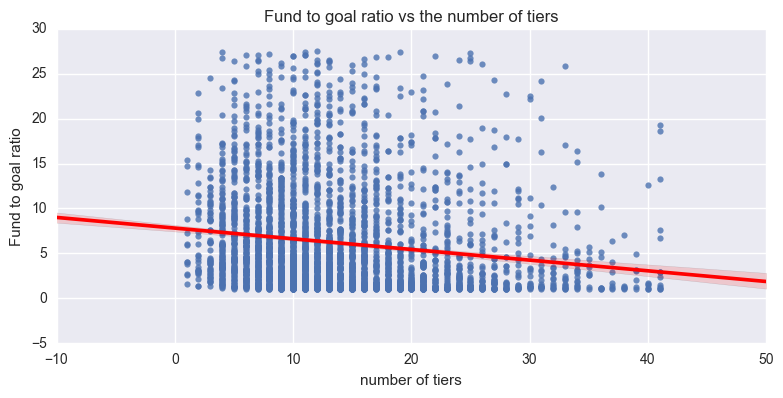

In [16]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
from __future__ import unicode_literals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
from datetime import datetime

#The dataset from webrobots.io consists of multiple csv files. Here we read and store them in a pandas dataframe
path ='input/Kickstarter_2017-01-15/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f,index_col=None, header=0) for f in all_files)
kickall_df   = pd.concat(df_from_each_file, ignore_index=True)
kickall_df.shape

kickall_df['fund_goal_ratio'] =(kickall_df['pledged'] / kickall_df['goal'])
kickall_df['duration'] =[(datetime.fromtimestamp(int(kickall_df['deadline'][i]))-datetime.fromtimestamp(int(kickall_df['launched_at'][i]))).days for i,r in kickall_df.iterrows()]
kickall_df['success']=(kickall_df['state']=='successful')

#Remove outlier projects
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

ind_outlier=is_outlier(kickall_df['fund_goal_ratio'],thresh=5)
kickallN_df=kickall_df[~ind_outlier] # not outlier df
kickallN_df.shape

plt.hist(kickall_df['duration'], bins=90)
plt.show()

# Effect of a Campaign's Duraiton on Its Success
#Is there any meaningful realtion between a campaign length and its success. This study reveals a drop in the success rate once the duration exceeds 30 days. However, this observation seems not to be valid for campaigns longer than 60 days.

#avrage number of successful campaigns for each duration group 
ave_success=kickallN_df['success'].groupby(kickallN_df['duration']).sum()/kickallN_df['success'].groupby(kickallN_df['duration']).count()
plt.scatter(kickallN_df['duration'],kickallN_df['fund_goal_ratio'])
plt.plot(ave_success, color="red",  linewidth=2.5, linestyle="-",label='Average success rate')
plt.legend(loc='upper right')
plt.xlabel('campaign duration (days)')
plt.ylabel('fund to goal ratio')
plt.xlim(-2,92)
plt.title('Success rate vs campaign duration')
plt.grid(True)
plt.savefig("success-duration.png")
plt.show()

### Number of pledge tiers, is it important?
#For this analysis I am using the data from top 4000 most success campaigns on kickstarter from http://datapolymath.paperplane.io. 

# Reading in the data
kick_df=pd.read_csv('input/kickstarter_most_backed.csv',index_col=0)
kick_df['fund_goal_ratio'] =(kick_df['amt.pledged'] / kick_df['goal'])
kick_df['tiers_count'] =[len(eval(kick_df['pledge.tier'][i])) for i,r in kick_df.iterrows()]

#Remove outlier projects
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

#sns.jointplot(x="tiers_count", y="percent_funded", data=kickN_df, kind="reg", size=4);
duration_outliers=is_outlier(kick_df['fund_goal_ratio'],thresh=5)
fund_outliers=is_outlier(kick_df['tiers_count'],thresh=5)
kickN50_df=kick_df[(~duration_outliers)&(~fund_outliers)]
g=sns.lmplot('tiers_count', 'fund_goal_ratio', kickN50_df, sharex=False, sharey=False,size=4, aspect=2,line_kws={'color': 'red'})
plt.title('Fund to goal ratio vs the number of tiers')
plt.xlabel('number of tiers')
plt.ylabel('Fund to goal ratio')
plt.savefig("fund-tier.png")

C:\Users\madden4-64b\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


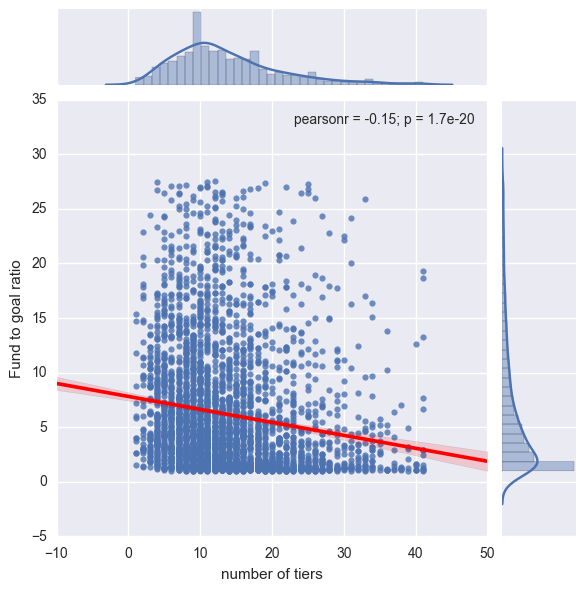

In [45]:
sns.jointplot(x="tiers_count", y="fund_goal_ratio", data=kickN50_df, kind="reg",line_kws={'color': 'red'})
#plt.title('Fund to goal ratio vs the number of tiers')
plt.xlabel('number of tiers')
plt.ylabel('Fund to goal ratio')

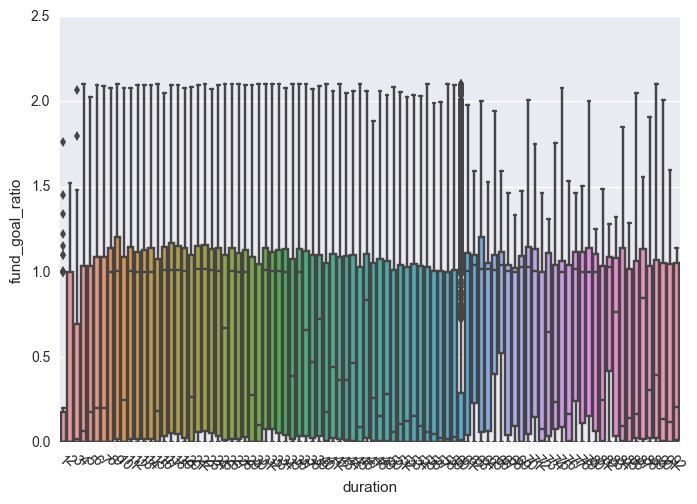

In [15]:
g=sns.boxplot(y='fund_goal_ratio', x='duration', data=kickallN_df)
for item in g.get_xticklabels():
    item.set_rotation(-45)

In [67]:
kick_data=kick_df
#rename some columns (not needed, I just used this data with other data with similar column names)
kick_data.rename(columns = {'amt.pledged' : 'pledged_amount'}, inplace=True)
kick_data.rename(columns = {'pledge.tier' : 'pledge_tier'}, inplace=True)
kick_data.rename(columns = {'num.backers' : 'backers'}, inplace=True)
kick_data.rename(columns = {'num.backers.tier' : 'backers_by_tier'}, inplace=True)
kick_data.rename(columns = {'blurb' : 'pitch'}, inplace=True)